In [14]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import gc
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Training on CPU")


Training on GPU: NVIDIA GeForce RTX 3080 Laptop GPU


In [1]:
# sys.path.insert(0, os.path.abspath('D:\Kaggle_Contest_Record\HMS_Harmful Brain Activity Classification'))
import sys
sys.path.insert(0, '../')

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from config.constants import *
from viz.plot import *
from features.statistical_features import*
from tracking.save_log import *

In [4]:
eeg_montage_path = f"{PROCESSED_DATA_DIR}/eeg_data_dict.pickle"
with open(eeg_montage_path, 'rb') as handle:
    eeg_data_dict = pickle.load(handle)
    


In [5]:
print(len(eeg_data_dict))

28387


Extract sampler

In [21]:
processed_sampler_data = []

for key, value in eeg_data_dict.items():
    data = value['data']  
    #已知data为3d数组，如何在这里把data缩减成以中心行为中心
    middle_point=len(data)//2
    data = data[middle_point-200*5:middle_point+200*5]
    targets = value['targets']
    
    processed_sample = SAMPLERrep_ver2(data)
    #standardized_sample = standardize_sample(processed_sample)
    standardized_sample = processed_sample
    flattened_sample = np.ravel(standardized_sample)
    
    processed_sampler_data.append(np.concatenate([flattened_sample, targets]))




Create dataset 

In [22]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feature, label

Create Multinomial LR Model

In [23]:
class SimpleMultinomialModelKL(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMultinomialModelKL, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        x = self.fc(x)
        log_probs = F.log_softmax(x, dim=1)  # log_softmax to fit KL-DIV
        return log_probs

Train function

In [24]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = 0
        # 训练过程
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            #target_log = torch.log(target+1e-8) 
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # 计算平均训练损失
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # 验证过程
        model.eval()  # 将模型设置为评估模式
        val_loss = 0
        with torch.no_grad():  # 在验证过程中不计算梯度
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                #target_log = torch.log(target+1e-8)
                loss = criterion(output, target)
                val_loss += loss.item()
                
        # 计算平均验证损失
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # 每50个epoch打印一次训练和验证损失
        if (epoch+1) % 50 == 0:
            print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            
    # 返回训练后的模型，以及训练和验证损失的列表
    return model, train_losses, val_losses


Train

In [25]:
#Hyper parameters
Batch_options = [32, 96, 168]
Lr_Options = [0.001, 0.0001]
Epoch_Options = []

In [26]:
def train_eeg_montage_and_sampler_only(processed_sampler_data, batch_size=32, lr=0.001, epochs=10, device='cuda'):
    
    processed_sampler_data = np.array(processed_sampler_data)
    
    features = processed_sampler_data[:, :-6]
    labels = processed_sampler_data[:, -6:]
    
    # train test split
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.3, random_state=42)
    
    # dataset
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    
    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 定义模型、优化器和损失函数
    sample_features, _ = next(iter(train_loader))
    input_dim = sample_features.shape[1]
    model = SimpleMultinomialModelKL(input_dim=input_dim, output_dim=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.KLDivLoss(reduction='batchmean').to(device)
    
    # 进行训练和验证
    model, train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device)
    log_training_results(log_path = LOG_PATH , 
    model_name = "One_Layer_Multinomial_LR", 
    params = {'epoch': epochs, 'lr': lr, 'batch_size': batch_size}, 
    results = {'val_loss': round(val_losses[-1], 4), 'train_loss': round(train_losses[-1], 4), 'F1': None, 'accuracy': None},
    notes = "LR from 10s eeg SMAPLER_no std")
    return model, train_losses, val_losses

In [12]:
gc.collect()

0

In [27]:
model, train_losses, val_losses = train_eeg_montage_and_sampler_only(processed_sampler_data, batch_size=68, lr=0.001, epochs=2000, device=device)

Epoch: 50, Training Loss: 39.3058, Validation Loss: 65.9087
Epoch: 100, Training Loss: 39.8192, Validation Loss: 67.0856
Epoch: 150, Training Loss: 40.3021, Validation Loss: 60.6122
Epoch: 200, Training Loss: 39.8540, Validation Loss: 100.0705
Epoch: 250, Training Loss: 32.6395, Validation Loss: 76.3680
Epoch: 300, Training Loss: 32.4915, Validation Loss: 49.4374
Epoch: 350, Training Loss: 55.4742, Validation Loss: 116.2894
Epoch: 400, Training Loss: 29.4165, Validation Loss: 56.0819
Epoch: 450, Training Loss: 36.4000, Validation Loss: 94.6752
Epoch: 500, Training Loss: 40.7785, Validation Loss: 134.0173
Epoch: 550, Training Loss: 37.8805, Validation Loss: 42.9366
Epoch: 600, Training Loss: 33.0240, Validation Loss: 79.0553
Epoch: 650, Training Loss: 36.4309, Validation Loss: 67.1039
Epoch: 700, Training Loss: 31.0005, Validation Loss: 112.1550
Epoch: 750, Training Loss: 30.8658, Validation Loss: 64.5675
Epoch: 800, Training Loss: 34.3047, Validation Loss: 50.5372
Epoch: 850, Training 

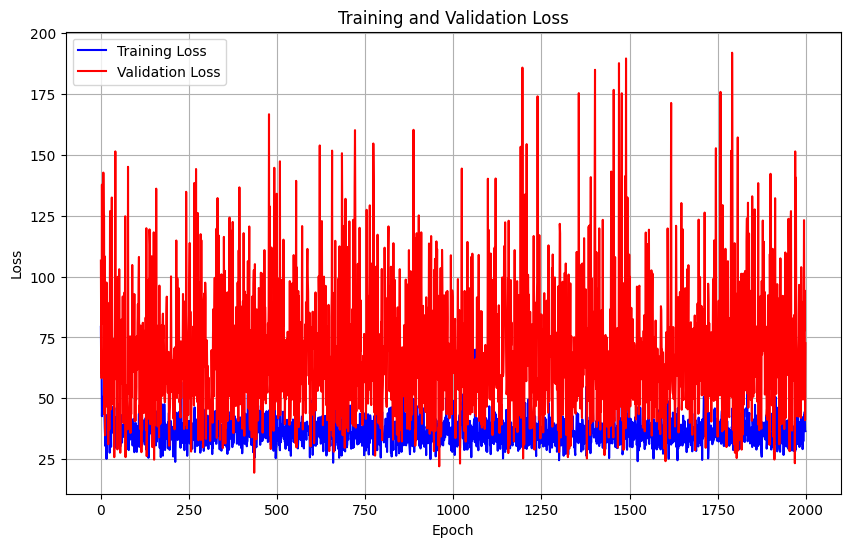

In [28]:
plot_loss_curves(train_losses, val_losses, title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
